<a href="https://colab.research.google.com/github/Polydany0/Digital-Image-Processing/blob/main/Cvt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Явная установка совместимых версий библиотек
!pip install -U torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install -U transformers pillow requests matplotlib

Looking in indexes: https://download.pytorch.org/whl/cu118


In [2]:
# Импорт необходимых библиотек
from transformers import AutoFeatureExtractor, CvtForImageClassification
from PIL import Image
import requests
import matplotlib.pyplot as plt
import torch
import random
from io import BytesIO
import numpy as np

In [3]:
# Список API для случайных изображений кошек
CAT_API_SOURCES = [
    "https://cataas.com/cat",
    "https://api.thecatapi.com/v1/images/search",
    "https://placekitten.com/{width}/{height}",
    "https://aws.random.cat/meow"
]

In [4]:
def get_random_cat_image():
    """Загружает случайное изображение кошки с различных API"""
    source = random.choice(CAT_API_SOURCES)

    try:
        if "placekitten" in source:
            width, height = random.randint(300, 600), random.randint(300, 600)
            url = source.format(width=width, height=height)
            response = requests.get(url, timeout=10)
            return Image.open(BytesIO(response.content))

        elif "thecatapi" in source or "random.cat" in source:
            json_data = requests.get(source, timeout=10).json()
            url = json_data[0]['url'] if isinstance(json_data, list) else json_data['file']
            response = requests.get(url, timeout=10)
            return Image.open(BytesIO(response.content))

        else:
            response = requests.get(source, timeout=10)
            return Image.open(BytesIO(response.content))

    except Exception as e:
        print(f"⚠️ Ошибка при загрузке из {source}: {e}")
        return Image.open(requests.get(
            "http://images.cocodataset.org/val2017/000000039769.jpg",
            stream=True
        ).raw)

In [5]:
# Загрузка модели и процессора CvT
print("\n🔄 Загрузка модели CvT-13 от Microsoft...")
feature_extractor = AutoFeatureExtractor.from_pretrained("microsoft/cvt-13")
model = CvtForImageClassification.from_pretrained("microsoft/cvt-13")
print("✅ Модель успешно загружена!")

# Получение информации о модели
print(f"\nℹ️ Модель: {model.config.model_type}")
print(f"ℹ️ Размер изображения: {feature_extractor.size}")
print(f"ℹ️ Количество классов: {model.config.num_labels}")


🔄 Загрузка модели CvT-13 от Microsoft...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/266 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/convnext/feature_extraction_convnext.py:30: FutureWarning: The class ConvNextFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ConvNextImageProcessor instead.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/80.2M [00:00<?, ?B/s]

✅ Модель успешно загружена!

ℹ️ Модель: cvt
ℹ️ Размер изображения: {'shortest_edge': 224}
ℹ️ Количество классов: 1000



🚀 Обработка изображения 1/4...
  🎯 Предсказание: Blenheim spaniel
  🔒 Уверенность: 12.86%

🚀 Обработка изображения 2/4...
  🎯 Предсказание: Border collie
  🔒 Уверенность: 9.12%

🚀 Обработка изображения 3/4...
  🎯 Предсказание: Egyptian cat
  🔒 Уверенность: 41.46%

🚀 Обработка изображения 4/4...
⚠️ Ошибка при загрузке из https://placekitten.com/{width}/{height}: cannot identify image file <_io.BytesIO object at 0x7d54c03ae4d0>
  🎯 Предсказание: tabby, tabby cat
  🔒 Уверенность: 57.72%


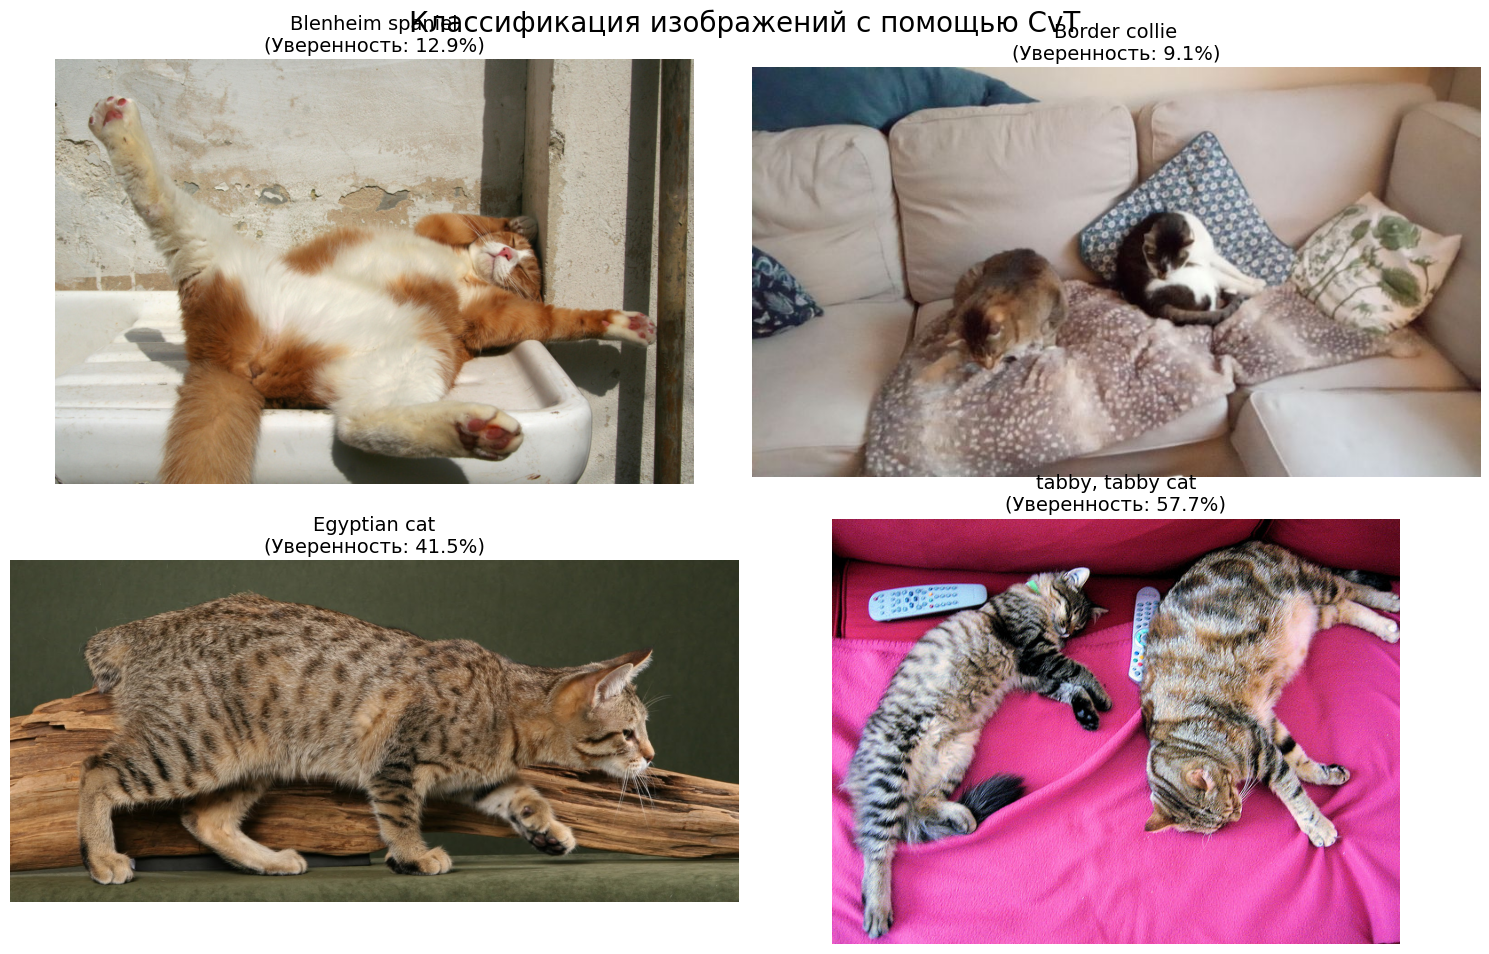


✅ Классификация завершена!


In [6]:
# Создание сетки изображений
num_images = 4
plt.figure(figsize=(15, 10))
plt.suptitle('Классификация изображений с помощью CvT', fontsize=20, y=0.95)

for i in range(num_images):
    # Загрузка и обработка изображения
    print(f"\n🚀 Обработка изображения {i+1}/{num_images}...")
    image = get_random_cat_image()

    # Преобразование в RGB если необходимо
    if image.mode != 'RGB':
        image = image.convert('RGB')

    # Предобработка и классификация
    inputs = feature_extractor(images=image, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs)

    # Обработка результатов
    logits = outputs.logits
    probabilities = torch.nn.functional.softmax(logits, dim=-1)[0]
    predicted_idx = logits.argmax(-1).item()
    predicted_label = model.config.id2label[predicted_idx]
    confidence = probabilities[predicted_idx].item() * 100

    print(f"  🎯 Предсказание: {predicted_label}")
    print(f"  🔒 Уверенность: {confidence:.2f}%")

    # Отображение в сетке
    ax = plt.subplot(2, 2, i+1)
    plt.imshow(image)
    plt.title(f"{predicted_label}\n(Уверенность: {confidence:.1f}%)", fontsize=14)
    plt.axis('off')

plt.tight_layout()
plt.subplots_adjust(top=0.90)
plt.show()
print("\n" + "="*50)
print("✅ Классификация завершена!")
print("="*50)